In [1]:
include("detect.jl")

include("ssd4.jl")
include("config.jl")
include("helpers.jl")
include("detect.jl")
include("visualizations.jl")
include("dataset.jl")
include("transformations.jl")
include("evaluate.jl");
include("detect.jl")
include("dataset.jl")
include("utilities.jl")
include("evaluate.jl")

calculate_mAP (generic function with 1 method)

In [2]:
atype = CUDA.functional() ? KnetArray{Float32} : Array{Float32}

KnetArray{Float32,N} where N

In [3]:
batch_size = 32
watercolor_dt_path = "/home/ckoksal20/Desktop/crossdomainDataset/dt_watercolor"
annotation_path_watercolor_VOC2007 ="$watercolor_dt_path/VOC2007/Annotations"
images_path_watercolor_VOC2007 = "$watercolor_dt_path/VOC2007/JPEGImages"
main_path_watercolor_VOC2007 =  "$watercolor_dt_path/VOC2007/ImageSets/Main"

annotation_path_watercolor_VOC2012 ="$watercolor_dt_path/VOC2012/Annotations"
images_path_watercolor_VOC2012 = "$watercolor_dt_path/VOC2012/JPEGImages"
main_path_watercolor_VOC2012 =  "$watercolor_dt_path/VOC2012/ImageSets/Main"


trainval_watercolor_VOC2007 = "$main_path_watercolor_VOC2007/trainval.txt"
trainval_watercolor_VOC2012 = "$main_path_watercolor_VOC2012/trainval.txt"





"/home/ckoksal20/Desktop/crossdomainDataset/dt_watercolor/VOC2012/ImageSets/Main/trainval.txt"

In [4]:
watercolor_path = "/home/ckoksal20/Desktop/crossdomainDataset/watercolor"
annotation_path_watercolor= "$watercolor_path/Annotations"
images_path_watercolor= "$watercolor_path/JPEGImages"
main_path_watercolor =  "$watercolor_path/ImageSets/Main"
test_watercolor = "$main_path_watercolor/test.txt"
watercolor_test = PascalVOC(test_watercolor, annotation_path_watercolor
    , images_path_watercolor,"TEST",dtype = atype, batchsize =batch_size)


PascalVOC(["43248445", "91846963", "250278059", "34017759", "37121775", "231499133", "195460703", "77220385", "164909305", "118984069"  …  "188608889", "145836317", "119556533", "23828359", "26103211", "196386523", "156742709", "233327391", "234988509", "90721223"], 32, false, 1000, true, "TEST", "/home/ckoksal20/Desktop/crossdomainDataset/watercolor/Annotations", "/home/ckoksal20/Desktop/crossdomainDataset/watercolor/JPEGImages", KnetArray{Float32,N} where N, false, Any[])

In [6]:


function initopt!(model::SSD300, startLr = 1e-3,gclip = 0)
    for par in params(model)
        # Authors initialzied learning rates of bias 2x of weights learning rate
        if size(par)[1:2] == (1,1) && size(par)[end] == 1 #bias
            par.opt = Momentum(;lr=2*startLr, gclip=0, gamma = 0.9)
        else
            par.opt = Momentum(;lr=startLr, gclip=0,gamma = 0.9)
        end
    end
end
   
function currentTime()
    dt = now()
    return Dates.format(dt, "yyyy-mm-dd_HH:MM:SS")
end

function finetune!(model::SSD300, train_data, test_data::PascalVOC,epochs
                  ;period::Int=2000, learning_rate_decay = 0.1 )
    
    train_loss = []
    test_loss = []
    iteration = 0
    curTime = currentTime()
    tr_loss = 0
    tst_loss = 0
    println("Training has started ", "length train_data : ",length(train_data), "Expected epochs : ",epochs)
    
    filename="log_ssd300_DT_VOC2007_2012trainval_l1_batch_$batch_size-iteration_$iterations-$curTime.txt"
    for epoch in 1:epochs
        start_epoch_time = now()
        println("Epoch : ", epoch, " has started")
       
        for (x,bounding_boxes,labels,_) in train_data
            println("Current iteration ", iteration)
           
        
            if iteration%period == 0
                tr_loss = 0
                tr_loss = model(train_data) 
                tst_loss = model(test_data)
                println("Iteration ", iteration, " training loss : ",tr_loss, " test_loss : ",tst_loss)

                append!(train_loss,tr_loss )
                append!(test_loss,tst_loss )
            end
            
            momentum!(ssd300,[(x,bounding_boxes,labels)])
            iteration +=1
        end
    end_epoch_time = now()
    elapsed_time = ((end_epoch_time -start_epoch_time).value)/1000/60
    
        
    Knet.save("/home/ckoksal20/Desktop/logfiles/ssd300_watercolor_dt.jld2","model",ssd300)
    println("Elapsed time $elapsed_time min epoch : $epoch\n")    
    open("/home/ckoksal20/Desktop/logfiles/$filename", "a") do f
        write(f, "Elapsed time $elapsed_time min epoch : $epoch\n")
        #write(f,"Iteration: $iteration, training loss : $tr_loss, test_loss : $tst_loss \n")
    end
    end
        
    return 0:period:iteration, train_loss, test_loss
end




finetune! (generic function with 1 method)

In [7]:
batch_size = 4

watercolor_train = PascalVOC([trainval_watercolor_VOC2007,trainval_watercolor_VOC2012], 
    [annotation_path_watercolor_VOC2007,annotation_path_watercolor_VOC2012],
    
    [images_path_watercolor_VOC2007,images_path_watercolor_VOC2012],
    "TEST",dtype = atype, batchsize =batch_size, multi_dataset=true)



watercolor_path = "/home/ckoksal20/Desktop/crossdomainDataset/watercolor"
annotation_path_watercolor= "$watercolor_path/Annotations"
images_path_watercolor= "$watercolor_path/JPEGImages"
main_path_watercolor =  "$watercolor_path/ImageSets/Main"
test_watercolor = "$main_path_watercolor/test.txt"
watercolor_test = PascalVOC(test_watercolor, annotation_path_watercolor
    , images_path_watercolor,"TEST",dtype = atype, batchsize =batch_size,shuffle=true)


ssd300 = SSD300(pretrained = true)

before_ft_APs, before_ft_mAP  = evaluate(watercolor_test,ssd300)


initopt!(ssd300, 1e-6)



iterations = 1000
epochs = round(iterations/length(watercolor_train))
epochs=1

iters, trnloss, tstloss = finetune!(ssd300,watercolor_train,watercolor_test,epochs)
after_finetune_ap,after_finetune_Map = evaluate(watercolor_test,ssd300)


Pretrained constructor is called
 Iteration : 1
 Iteration : 2
 Iteration : 3
 Iteration : 4
 Iteration : 5
 Iteration : 6
 Iteration : 7
 Iteration : 8
 Iteration : 9
 Iteration : 10
 Iteration : 11
 Iteration : 12
 Iteration : 13
 Iteration : 14
 Iteration : 15
 Iteration : 16
 Iteration : 17
 Iteration : 18
 Iteration : 19
 Iteration : 20
 Iteration : 21
 Iteration : 22
 Iteration : 23
 Iteration : 24
 Iteration : 25
 Iteration : 26
 Iteration : 27
 Iteration : 28
 Iteration : 29
 Iteration : 30
 Iteration : 31
 Iteration : 32
 Iteration : 33
 Iteration : 34
 Iteration : 35
 Iteration : 36
 Iteration : 37
 Iteration : 38
 Iteration : 39
 Iteration : 40
 Iteration : 41
 Iteration : 42
 Iteration : 43
 Iteration : 44
 Iteration : 45
 Iteration : 46
 Iteration : 47
 Iteration : 48
 Iteration : 49
 Iteration : 50
 Iteration : 51
 Iteration : 52
 Iteration : 53
 Iteration : 54
 Iteration : 55
 Iteration : 56
 Iteration : 57
 Iteration : 58
 Iteration : 59
 Iteration : 60
 Iteration : 61


Current iteration 148
Current iteration 149
Current iteration 150
Current iteration 151
Current iteration 152
Current iteration 153
Current iteration 154
Current iteration 155
Current iteration 156
Current iteration 157
Current iteration 158
Current iteration 159
Current iteration 160
Current iteration 161
Current iteration 162
Current iteration 163
Current iteration 164
Current iteration 165
Current iteration 166
Current iteration 167
Current iteration 168
Current iteration 169
Current iteration 170
Current iteration 171
Current iteration 172
Current iteration 173
Current iteration 174
Current iteration 175
Current iteration 176
Current iteration 177
Current iteration 178
Current iteration 179
Current iteration 180
Current iteration 181
Current iteration 182
Current iteration 183
Current iteration 184
Current iteration 185
Current iteration 186
Current iteration 187
Current iteration 188
Current iteration 189
Current iteration 190
Current iteration 191
Current iteration 192
Current it

Current iteration 520
Current iteration 521
Current iteration 522
Current iteration 523
Current iteration 524
Current iteration 525
Current iteration 526
Current iteration 527
Current iteration 528
Current iteration 529
Current iteration 530
Current iteration 531
Current iteration 532
Current iteration 533
Current iteration 534
Current iteration 535
Current iteration 536
Current iteration 537
Current iteration 538
Current iteration 539
Current iteration 540
Current iteration 541
Current iteration 542
Current iteration 543
Current iteration 544
Current iteration 545
Current iteration 546
Current iteration 547
Current iteration 548
Current iteration 549
Current iteration 550
Current iteration 551
Current iteration 552
Current iteration 553
Current iteration 554
Current iteration 555
Current iteration 556
Current iteration 557
Current iteration 558
Current iteration 559
Current iteration 560
Current iteration 561
Current iteration 562
Current iteration 563
Current iteration 564
Current it

Current iteration 892
Current iteration 893
Current iteration 894
Current iteration 895
Current iteration 896
Current iteration 897
Current iteration 898
Current iteration 899
Current iteration 900
Current iteration 901
Current iteration 902
Current iteration 903
Current iteration 904
Current iteration 905
Current iteration 906
Current iteration 907
Current iteration 908
Current iteration 909
Current iteration 910
Current iteration 911
Current iteration 912
Current iteration 913
Current iteration 914
Current iteration 915
Current iteration 916
Current iteration 917
Current iteration 918
Current iteration 919
Current iteration 920
Current iteration 921
Current iteration 922
Current iteration 923
Current iteration 924
Current iteration 925
Current iteration 926
Current iteration 927
Current iteration 928
Current iteration 929
Current iteration 930
Current iteration 931
Current iteration 932
Current iteration 933
Current iteration 934
Current iteration 935
Current iteration 936
Current it

Current iteration 1253
Current iteration 1254
Current iteration 1255
Current iteration 1256
Current iteration 1257
Current iteration 1258
Current iteration 1259
Current iteration 1260
Current iteration 1261
Current iteration 1262
Current iteration 1263
Current iteration 1264
Current iteration 1265
Current iteration 1266
Current iteration 1267
Current iteration 1268
Current iteration 1269
Current iteration 1270
Current iteration 1271
Current iteration 1272
Current iteration 1273
Current iteration 1274
Current iteration 1275
Current iteration 1276
Current iteration 1277
Current iteration 1278
Current iteration 1279
Current iteration 1280
Current iteration 1281
Current iteration 1282
Current iteration 1283
Current iteration 1284
Current iteration 1285
Current iteration 1286
Current iteration 1287
Current iteration 1288
Current iteration 1289
Current iteration 1290
Current iteration 1291
Current iteration 1292
Current iteration 1293
Current iteration 1294
Current iteration 1295
Current ite

Current iteration 1610
Current iteration 1611
Current iteration 1612
Current iteration 1613
Current iteration 1614
Current iteration 1615
Current iteration 1616
Current iteration 1617
Current iteration 1618
Current iteration 1619
Current iteration 1620
Current iteration 1621
Current iteration 1622
Current iteration 1623
Current iteration 1624
Current iteration 1625
Current iteration 1626
Current iteration 1627
Current iteration 1628
Current iteration 1629
Current iteration 1630
Current iteration 1631
Current iteration 1632
Current iteration 1633
Current iteration 1634
Current iteration 1635
Current iteration 1636
Current iteration 1637
Current iteration 1638
Current iteration 1639
Current iteration 1640
Current iteration 1641
Current iteration 1642
Current iteration 1643
Current iteration 1644
Current iteration 1645
Current iteration 1646
Current iteration 1647
Current iteration 1648
Current iteration 1649
Current iteration 1650
Current iteration 1651
Current iteration 1652
Current ite

Current iteration 1966
Current iteration 1967
Current iteration 1968
Current iteration 1969
Current iteration 1970
Current iteration 1971
Current iteration 1972
Current iteration 1973
Current iteration 1974
Current iteration 1975
Current iteration 1976
Current iteration 1977
Current iteration 1978
Current iteration 1979
Current iteration 1980
Current iteration 1981
Current iteration 1982
Current iteration 1983
Current iteration 1984
Current iteration 1985
Current iteration 1986
Current iteration 1987
Current iteration 1988
Current iteration 1989
Current iteration 1990
Current iteration 1991
Current iteration 1992
Current iteration 1993
Current iteration 1994
Current iteration 1995
Current iteration 1996
Current iteration 1997
Current iteration 1998
Current iteration 1999
Current iteration 2000
Dataset Loss is being calculated
Dataset Loss is being calculated
Iteration 2000 training loss : 7.134663933192263 test_loss : 7.323917668734561
Current iteration 2001
Current iteration 2002
Curr

Current iteration 2316
Current iteration 2317
Current iteration 2318
Current iteration 2319
Current iteration 2320
Current iteration 2321
Current iteration 2322
Current iteration 2323
Current iteration 2324
Current iteration 2325
Current iteration 2326
Current iteration 2327
Current iteration 2328
Current iteration 2329
Current iteration 2330
Current iteration 2331
Current iteration 2332
Current iteration 2333
Current iteration 2334
Current iteration 2335
Current iteration 2336
Current iteration 2337
Current iteration 2338
Current iteration 2339
Current iteration 2340
Current iteration 2341
Current iteration 2342
Current iteration 2343
Current iteration 2344
Current iteration 2345
Current iteration 2346
Current iteration 2347
Current iteration 2348
Current iteration 2349
Current iteration 2350
Current iteration 2351
Current iteration 2352
Current iteration 2353
Current iteration 2354
Current iteration 2355
Current iteration 2356
Current iteration 2357
Current iteration 2358
Current ite

Current iteration 2673
Current iteration 2674
Current iteration 2675
Current iteration 2676
Current iteration 2677
Current iteration 2678
Current iteration 2679
Current iteration 2680
Current iteration 2681
Current iteration 2682
Current iteration 2683
Current iteration 2684
Current iteration 2685
Current iteration 2686
Current iteration 2687
Current iteration 2688
Current iteration 2689
Current iteration 2690
Current iteration 2691
Current iteration 2692
Current iteration 2693
Current iteration 2694
Current iteration 2695
Current iteration 2696
Current iteration 2697
Current iteration 2698
Current iteration 2699
Current iteration 2700
Current iteration 2701
Current iteration 2702
Current iteration 2703
Current iteration 2704
Current iteration 2705
Current iteration 2706
Current iteration 2707
Current iteration 2708
Current iteration 2709
Current iteration 2710
Current iteration 2711
Current iteration 2712
Current iteration 2713
Current iteration 2714
Current iteration 2715
Current ite

Current iteration 3029
Current iteration 3030
Current iteration 3031
Current iteration 3032
Current iteration 3033
Current iteration 3034
Current iteration 3035
Current iteration 3036
Current iteration 3037
Current iteration 3038
Current iteration 3039
Current iteration 3040
Current iteration 3041
Current iteration 3042
Current iteration 3043
Current iteration 3044
Current iteration 3045
Current iteration 3046
Current iteration 3047
Current iteration 3048
Current iteration 3049
Current iteration 3050
Current iteration 3051
Current iteration 3052
Current iteration 3053
Current iteration 3054
Current iteration 3055
Current iteration 3056
Current iteration 3057
Current iteration 3058
Current iteration 3059
Current iteration 3060
Current iteration 3061
Current iteration 3062
Current iteration 3063
Current iteration 3064
Current iteration 3065
Current iteration 3066
Current iteration 3067
Current iteration 3068
Current iteration 3069
Current iteration 3070
Current iteration 3071
Current ite

Current iteration 3385
Current iteration 3386
Current iteration 3387
Current iteration 3388
Current iteration 3389
Current iteration 3390
Current iteration 3391
Current iteration 3392
Current iteration 3393
Current iteration 3394
Current iteration 3395
Current iteration 3396
Current iteration 3397
Current iteration 3398
Current iteration 3399
Current iteration 3400
Current iteration 3401
Current iteration 3402
Current iteration 3403
Current iteration 3404
Current iteration 3405
Current iteration 3406
Current iteration 3407
Current iteration 3408
Current iteration 3409
Current iteration 3410
Current iteration 3411
Current iteration 3412
Current iteration 3413
Current iteration 3414
Current iteration 3415
Current iteration 3416
Current iteration 3417
Current iteration 3418
Current iteration 3419
Current iteration 3420
Current iteration 3421
Current iteration 3422
Current iteration 3423
Current iteration 3424
Current iteration 3425
Current iteration 3426
Current iteration 3427
Current ite

Current iteration 3741
Current iteration 3742
Current iteration 3743
Current iteration 3744
Current iteration 3745
Current iteration 3746
Current iteration 3747
Current iteration 3748
Current iteration 3749
Current iteration 3750
Current iteration 3751
Current iteration 3752
Current iteration 3753
Current iteration 3754
Current iteration 3755
Current iteration 3756
Current iteration 3757
Current iteration 3758
Current iteration 3759
Current iteration 3760
Current iteration 3761
Current iteration 3762
Current iteration 3763
Current iteration 3764
Current iteration 3765
Current iteration 3766
Current iteration 3767
Current iteration 3768
Current iteration 3769
Current iteration 3770
Current iteration 3771
Current iteration 3772
Current iteration 3773
Current iteration 3774
Current iteration 3775
Current iteration 3776
Current iteration 3777
Current iteration 3778
Current iteration 3779
Current iteration 3780
Current iteration 3781
Current iteration 3782
Current iteration 3783
Current ite

Current iteration 4091
Current iteration 4092
Current iteration 4093
Current iteration 4094
Current iteration 4095
Current iteration 4096
Current iteration 4097
Current iteration 4098
Current iteration 4099
Current iteration 4100
Current iteration 4101
Current iteration 4102
Current iteration 4103
Current iteration 4104
Current iteration 4105
Current iteration 4106
Current iteration 4107
Current iteration 4108
Current iteration 4109
Current iteration 4110
Current iteration 4111
Current iteration 4112
Current iteration 4113
Current iteration 4114
Current iteration 4115
Current iteration 4116
Current iteration 4117
Current iteration 4118
Current iteration 4119
Current iteration 4120
Current iteration 4121
Current iteration 4122
Current iteration 4123
Current iteration 4124
Current iteration 4125
Current iteration 4126
Current iteration 4127
Current iteration 4128
Current iteration 4129
Current iteration 4130
Current iteration 4131
Current iteration 4132
Current iteration 4133
Current ite

(0.1279076820207964, Dict("tvmonitor" => 0.0,"pottedplant" => 0.0,"bus" => 0.0,"boat" => 0.0,"train" => 0.0,"sofa" => 0.0,"sheep" => 0.0,"horse" => 0.0,"diningtable" => 0.0,"aeroplane" => 0.0…))

In [13]:
trnloss

3-element Array{Any,1}:
 8.62112445038464
 7.134663933192263
 6.954204334362876

In [18]:
import Pkg; Pkg.add("Plots")

   Updating registry at `~/.julia/registries/General`
######################################################################### 100,0%
  Resolving package versions...
  Installed LibVPX_jll ────────────────── v1.9.0+1
  Installed Ogg_jll ───────────────────── v1.3.4+2
  Installed IteratorInterfaceExtensions ─ v1.0.0
  Installed Tables ────────────────────── v1.2.2
  Installed GeometryBasics ────────────── v0.3.5
  Installed Plots ─────────────────────── v1.10.1
  Installed Opus_jll ──────────────────── v1.3.1+3
  Installed FFMPEG_jll ────────────────── v4.3.1+4
  Installed StructArrays ──────────────── v0.4.2
  Installed Grisu ─────────────────────── v1.0.0
  Installed FFMPEG ────────────────────── v0.4.0
  Installed libfdk_aac_jll ────────────── v0.1.6+4
  Installed Showoff ───────────────────── v0.3.2
  Installed LAME_jll ──────────────────── v3.100.0+3
  Installed libvorbis_jll ─────────────── v1.3.6+6
  Installed Formatting ────────────────── v0.4.2
  Installed LaTeXStrings ───────

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278


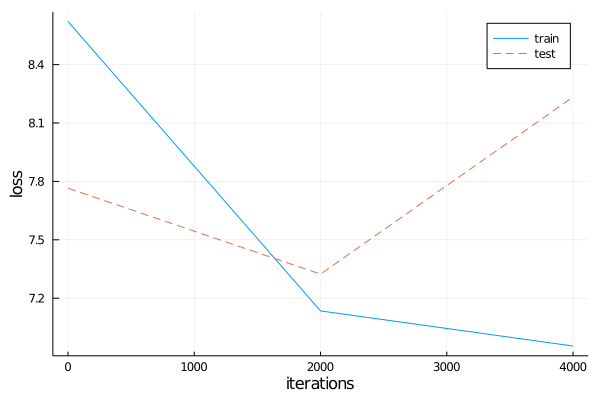

In [19]:
using Plots; default(fmt = :png, ls=:auto)
plot(iters, trnloss, label="train",xlabel ="iterations", ylabel = "loss")
plot!(iters, tstloss, label = "test")

In [8]:
function subsetMAP(mAP)
    subset_elements = ["bird","bicycle","cat","car","dog","person"]
    num_subsetElements = size(subset_elements,1)
    total_map = 0
    for (k,v) in mAP
        if k in subset_elements
            total_map += v
        end
        
    end
    return total_map / num_subsetElements
end

subsetMAP (generic function with 1 method)

In [9]:
subsetMAP(before_ft_mAP)

0.46983176041565705

In [10]:
before_ft_mAP

Dict{String,Float64} with 20 entries:
  "tvmonitor"   => 0.0
  "pottedplant" => 0.0
  "bus"         => 0.0
  "boat"        => 0.0
  "train"       => 0.0
  "sofa"        => 0.0
  "sheep"       => 0.0
  "horse"       => 0.0
  "diningtable" => 0.0
  "aeroplane"   => 0.0
  "person"      => 0.578635
  "chair"       => 0.0
  "dog"         => 0.303326
  "bottle"      => 0.0
  "cow"         => 0.0
  "car"         => 0.428996
  "motorbike"   => 0.0
  "cat"         => 0.329545
  "bicycle"     => 0.737267
  "bird"        => 0.441221

In [11]:
subsetMAP(after_finetune_Map)

0.4263589400693213

In [12]:
after_finetune_Map

Dict{String,Float64} with 20 entries:
  "tvmonitor"   => 0.0
  "pottedplant" => 0.0
  "bus"         => 0.0
  "boat"        => 0.0
  "train"       => 0.0
  "sofa"        => 0.0
  "sheep"       => 0.0
  "horse"       => 0.0
  "diningtable" => 0.0
  "aeroplane"   => 0.0
  "person"      => 0.487255
  "chair"       => 0.0
  "dog"         => 0.303978
  "bottle"      => 0.0
  "cow"         => 0.0
  "car"         => 0.382579
  "motorbike"   => 0.0
  "cat"         => 0.258207
  "bicycle"     => 0.749097
  "bird"        => 0.377038